Documentation to be added soon

In [1]:
# Import packages
import pandas as pd
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, lognorm, t, cauchy, weibull_min
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 16})

# Import functions
from functions import slippage_increase, slippage_decrease, combined_backtest

In [2]:
# Inputs for all analyses
ticker = "SPY"
DTE_max = 30
DTE_min = 0
volume_min = 0
slippage_abs = 0.01
slippage_per = 1.0
window = 22

In [3]:
# Obtain options dataframe
options_df = pd.read_pickle(ticker+"_options_data.pkl")

# Data processing
## Underlying asset - SPY

In [4]:
## Volatility
# Implied Volatility is defined as the standard deviation of expected daily returns annualized
# Using VIX
max_date = options_df['[QUOTE_DATE]'].max()
min_date = options_df['[QUOTE_DATE]'].min()
if ticker == "SPY":
    VIX_ticker = "^VIX"
vix_data = yf.download(VIX_ticker, start=min_date, end=max_date)
Vol_IV = vix_data['Adj Close'] * 1/100

# Using actual (future) returns
hist_data_during = yf.download(ticker, start=min_date, end=max_date)
hist_data_during['Daily Return'] = hist_data_during['Adj Close'].pct_change().dropna()
daily_std = hist_data_during['Daily Return'].rolling(window=window).std()
Vol_RV = daily_std * np.sqrt(365)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


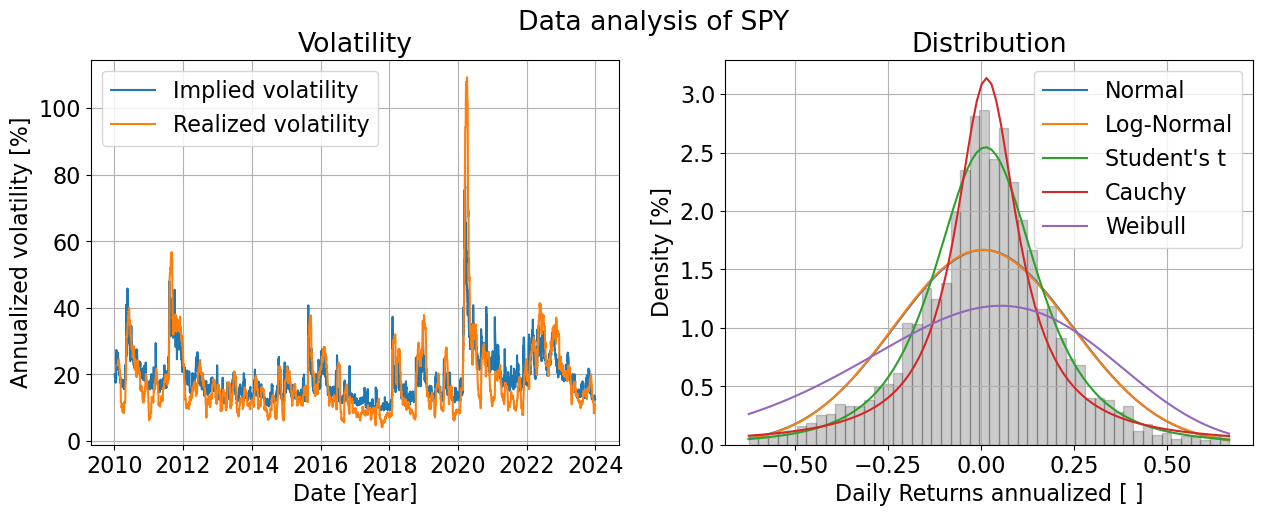

Student's t degrees of freedom : 2.83
Student's t mean (mu)          : 0.01


In [5]:
## Compare distributions
# Step 1: Data Retrieval
start_date = "1900-01-01"
end_date = "2009-12-31"
data = yf.download(ticker, start=start_date, end=end_date)
adj_close = data['Adj Close']

# Step 2: Calculate daily returns
daily_returns = adj_close.pct_change().dropna() * np.sqrt(365)

# Calculate 1st and 99th percentiles
percentile_1 = np.percentile(daily_returns, 1)
percentile_99 = np.percentile(daily_returns, 99)

# Filter data to include only values within 1st and 99th percentiles
filtered_data = daily_returns[(daily_returns >= percentile_1) & (daily_returns <= percentile_99)]

# Step 3: Plot Histogram of Daily Returns
plt.figure(figsize=(15, 5))
plt.suptitle('Data analysis of SPY')

plt.subplot(1,2,2)
plt.hist(filtered_data, bins=50, alpha=0.2, density=True, color='k', edgecolor='black')

# Step 4 & 5: Fit Distributions and Plot
distributions = {'Normal': norm, 'Log-Normal': lognorm, 'Student\'s t': t,
                 'Cauchy': cauchy, 'Weibull': weibull_min}

for name, dist in distributions.items():
    try:
        params = dist.fit(daily_returns)
        
        # Extract degrees of freedom parameter (t_df)
        if name == "Student's t":
            t_df = params[0]
            mu = params[1]
        
        fitted_distribution = dist(*params)
        x = np.linspace(min(filtered_data), max(filtered_data), 100)
        plt.plot(x, fitted_distribution.pdf(x), label=name)

    except:
        print(f"Could not fit distribution {name}")

# Plot
plt.title('SPY')
plt.xlabel('Daily Returns annualized [ ]')
plt.ylabel('Density [%]')
plt.title('Distribution')
plt.legend()
plt.grid()

plt.subplot(1,2,1)
plt.plot(vix_data.index, Vol_IV*100, label='Implied volatility')
plt.plot(hist_data_during.index, Vol_RV*100, label='Realized volatility')
plt.legend()
plt.grid()
plt.xlabel('Date [Year]')
plt.ylabel('Annualized volatility [%]')
plt.title('Volatility')

plt.show()

# Print fitted parameters
if t_df is not None and mu is not None:
    print(f"Student's t degrees of freedom : {t_df:.2f}")
    print(f"Student's t mean (mu)          : {mu:.2f}")

## Risk-free rate of return

[*********************100%%**********************]  1 of 1 completed


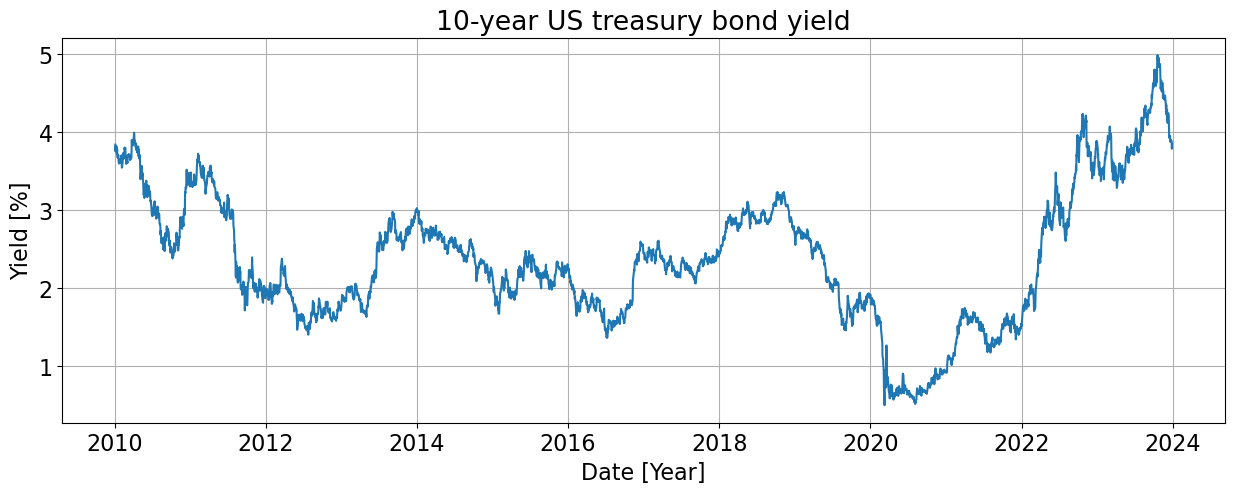

In [6]:
## Step 2.2: Obtain the risk free rate
# The risk free rate is assumed to be equal to the 10-year US treasury bond yield
# Using VIX
rfr_ticker = "^TNX"
rfr_data = yf.download(rfr_ticker, start=min_date, end=max_date)

RFR = rfr_data['Adj Close'] * 1/100
RFR = RFR.to_frame()
RFR.index.name = '[QUOTE_DATE]'
RFR = RFR.rename(columns={'Adj Close': 'RFR'})

# Merge the IV values into options_df
options_df = options_df.join(RFR, how='left')

# Rename the index of IV to match options_df for merging
RFR.index.name = '[QUOTE_DATE]'

# Ensure the index of IV is datetime if not already
RFR.index = pd.to_datetime(RFR.index)
options_df['[QUOTE_DATE]'] = pd.to_datetime(options_df['[QUOTE_DATE]'])

# Merge the IV values into options_df based on 'QUOTE_DATE'
options_df = options_df.merge(RFR, left_on='[QUOTE_DATE]', right_index=True, how='left', suffixes=('_delete', ''))
del options_df['RFR_delete']

plt.figure(figsize=(15, 5))
plt.plot(RFR.index, RFR['RFR']*100)
plt.grid()
plt.title('10-year US treasury bond yield')
plt.ylabel('Yield [%]')
plt.xlabel('Date [Year]')
plt.show()

# Analysis
## Data manipulation

In [7]:
## Delete the parts of the options_df that are not used
options_df = options_df[(options_df['[DTE]']>=DTE_min) & (options_df['[DTE]']<=DTE_max) & (options_df['[C_VOLUME]']>=volume_min) & (options_df['[P_VOLUME]']>=volume_min)\
                        & (options_df['[C_BID]']>0) & (options_df['[P_BID]']>0) & (options_df['[C_ASK]']>0) & (options_df['[P_ASK]']>0)]
del options_df['[C_DELTA]'], options_df['[P_DELTA]']

In [8]:
## Step 1.1: Create a column for the price at expiration

# Create a dictionary to map [EXPIRE_DATE] to the corresponding [UNDERLYING_LAST] on that date
expire_price_dict = options_df.set_index('[QUOTE_DATE]')['[UNDERLYING_LAST]'].to_dict()

# Create the expire_price column using the dictionary
options_df['expire_price'] = options_df['[EXPIRE_DATE]'].map(expire_price_dict)

In [9]:
## Step 1.2: Apply slippage to the options prices
options_df['[C_BID]'] = options_df['[C_BID]'].apply(slippage_increase, args=(slippage_abs, slippage_per))
options_df['[P_BID]'] = options_df['[P_BID]'].apply(slippage_increase, args=(slippage_abs, slippage_per))
options_df['[C_ASK]'] = options_df['[C_ASK]'].apply(slippage_decrease, args=(slippage_abs, slippage_per))
options_df['[P_ASK]'] = options_df['[P_ASK]'].apply(slippage_decrease, args=(slippage_abs, slippage_per))

In [10]:
## Step 1.3: Create columns for the trade results

# a) Buy call
options_df['buy call %'] = ((options_df['expire_price'] - options_df['[STRIKE]']).clip(lower=0) - options_df['[C_BID]']) / options_df['[C_BID]'] * 100.0

# b) Buy put
options_df['buy put %'] = ((options_df['[STRIKE]'] - options_df['expire_price']).clip(lower=0) - options_df['[P_BID]']) / options_df['[P_BID]'] * 100.0

print(options_df.head())

   [QUOTE_DATE]  [UNDERLYING_LAST] [EXPIRE_DATE]  [DTE]  [C_VOLUME]  [C_BID]  \
30   2010-01-04             113.29    2010-01-15   11.0         0.0   28.482   
33   2010-01-04             113.29    2010-01-15   11.0         0.0   25.452   
34   2010-01-04             113.29    2010-01-15   11.0         0.0   24.442   
36   2010-01-04             113.29    2010-01-15   11.0         2.0   22.422   
37   2010-01-04             113.29    2010-01-15   11.0         0.0   21.412   

    [C_ASK]  [STRIKE]  [P_BID]  [P_ASK]  [P_VOLUME]      RFR  expire_price  \
30  28.1160      85.0     0.03     0.01         5.0  0.03841           NaN   
33  25.1559      88.0     0.03     0.01         5.0  0.03841           NaN   
34  24.1659      89.0     0.02     0.02         9.0  0.03841           NaN   
36  22.1760      91.0     0.03     0.02       711.0  0.03841           NaN   
37  21.1959      92.0     0.04     0.03       108.0  0.03841           NaN   

    buy call %  buy put %  
30         NaN        

## Backtests

In [11]:
# Inputs
required_probability_per = 90
required_EV_per = 0
allocation_percentage = 20.0

# Output arrays
df_buy_mean_array = np.empty((2, 2), dtype=object)

In [12]:
for j, Vol_select in enumerate(['IV', 'RV']):

    for k, dist_select in enumerate(['norm', 't']):
        
        df_buy_mean_array[j,k] = combined_backtest(options_df, Vol_IV, Vol_RV, Vol_select, mu, t_df, dist_select, required_probability_per, required_EV_per, allocation_percentage)

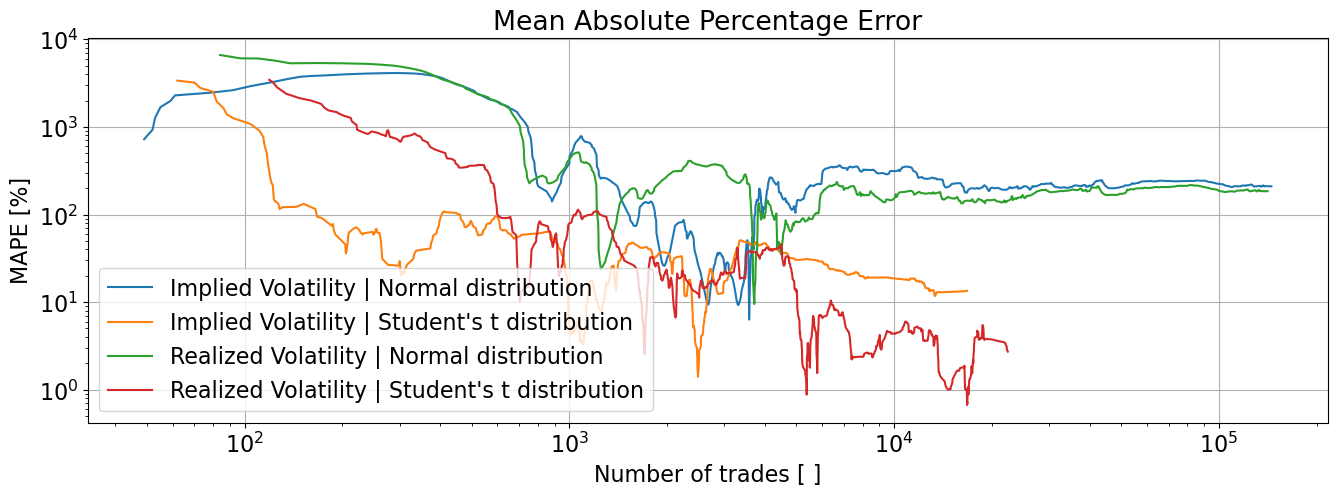

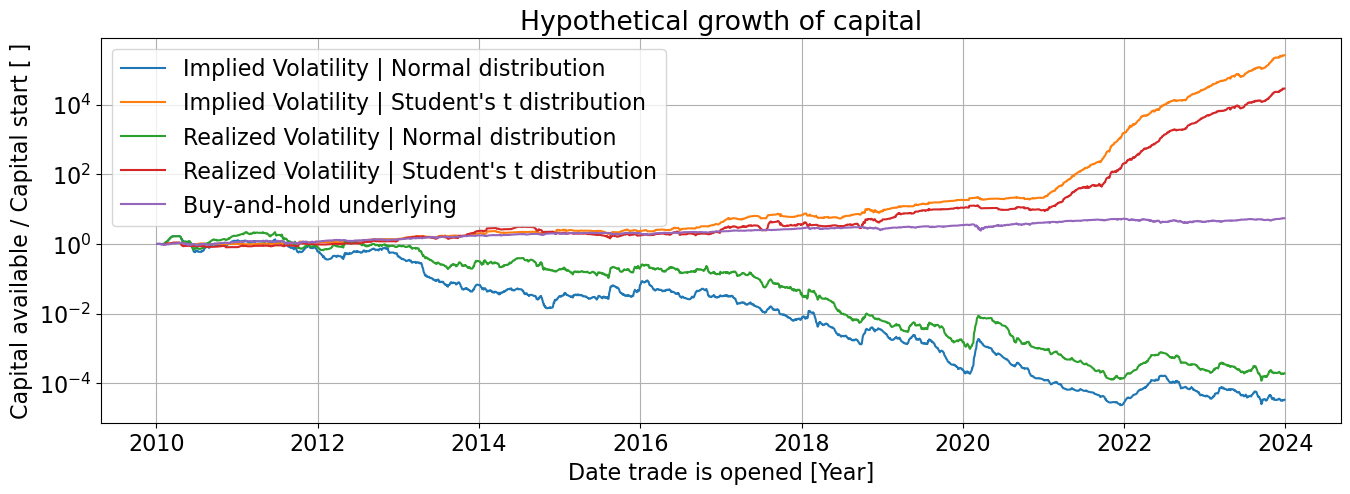

In [22]:
# Plot 1: MAPE comparison
plt.figure(figsize=(16, 5))
plt.plot(df_buy_mean_array[0,0]['N trades total'], df_buy_mean_array[0,0]['MAPE'].rolling(window=10).mean(), label='Implied Volatility | Normal distribution')
plt.plot(df_buy_mean_array[0,1]['N trades total'], df_buy_mean_array[0,1]['MAPE'].rolling(window=10).mean(), label='Implied Volatility | Student\'s t distribution')
plt.plot(df_buy_mean_array[1,0]['N trades total'], df_buy_mean_array[1,0]['MAPE'].rolling(window=10).mean(), label='Realized Volatility | Normal distribution')
plt.plot(df_buy_mean_array[1,1]['N trades total'], df_buy_mean_array[1,1]['MAPE'].rolling(window=10).mean(), label='Realized Volatility | Student\'s t distribution')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('MAPE [%]')
plt.xlabel('Number of trades [ ]')
plt.title('Mean Absolute Percentage Error')
plt.show()

# Plot 2: Capital growth comparison
plt.figure(figsize=(16, 5))
plt.plot(df_buy_mean_array[0,0].index, df_buy_mean_array[0,0]['Capital growth actual'], label='Implied Volatility | Normal distribution')
plt.plot(df_buy_mean_array[0,1].index, df_buy_mean_array[0,1]['Capital growth actual'], label='Implied Volatility | Student\'s t distribution')
plt.plot(df_buy_mean_array[1,0].index, df_buy_mean_array[1,0]['Capital growth actual'], label='Realized Volatility | Normal distribution')
plt.plot(df_buy_mean_array[1,1].index, df_buy_mean_array[1,1]['Capital growth actual'], label='Realized Volatility | Student\'s t distribution')
plt.plot(hist_data_during.index, hist_data_during['Adj Close']/hist_data_during['Adj Close'][0], label='Buy-and-hold underlying')
plt.legend()
plt.grid()
plt.yscale('log')
plt.xlabel('Date trade is opened [Year]')
plt.ylabel('Capital available / Capital start [ ]')
plt.title('Hypothetical growth of capital')
plt.show()

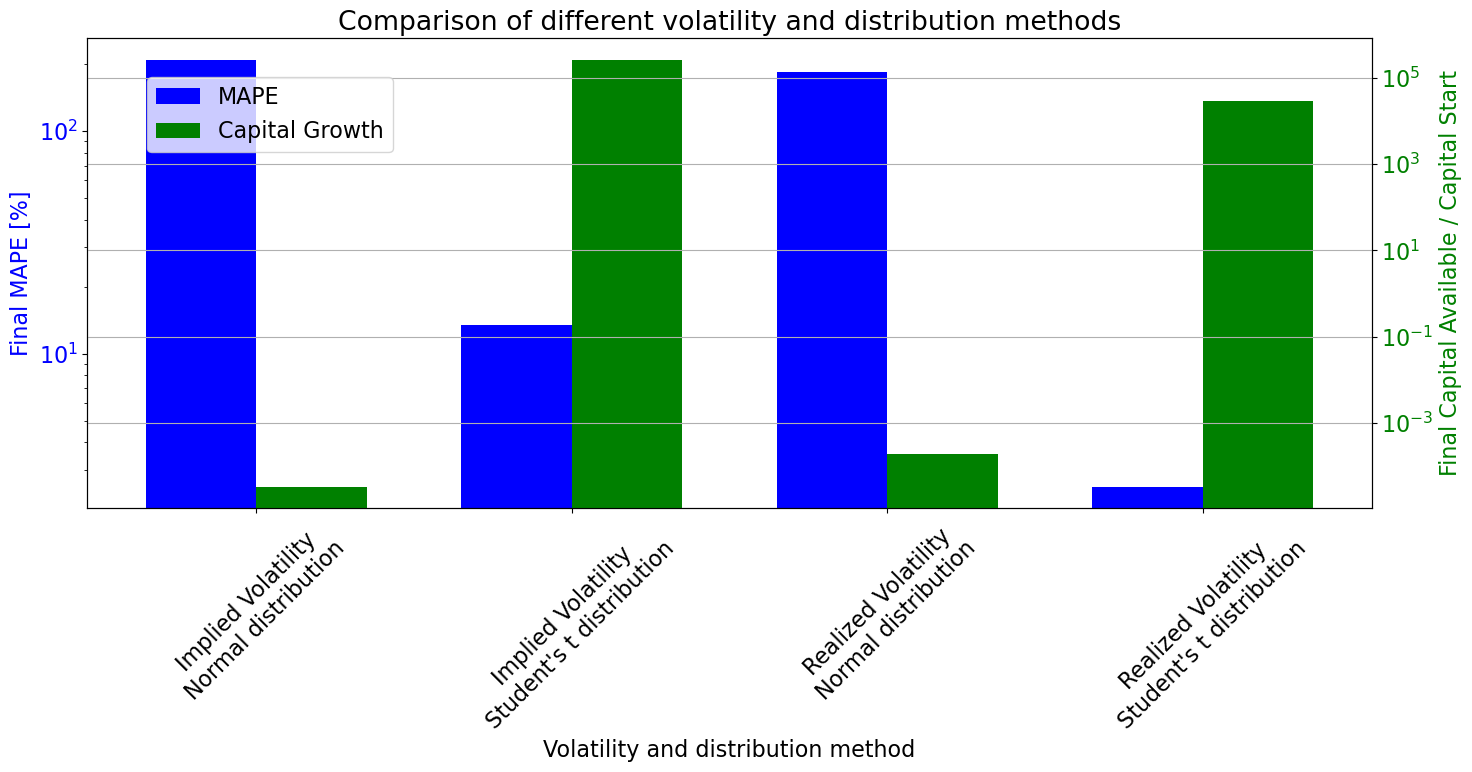

In [20]:
# Sample data for illustration purposes
labels = ['Implied Volatility\nNormal distribution', 'Implied Volatility\nStudent\'s t distribution',\
    'Realized Volatility\nNormal distribution', 'Realized Volatility\nStudent\'s t distribution']
mape_values = [df_buy_mean_array[0,0]['MAPE'].iloc[-1], df_buy_mean_array[0,1]['MAPE'].iloc[-1],\
    df_buy_mean_array[1,0]['MAPE'].iloc[-1], df_buy_mean_array[1,1]['MAPE'].iloc[-1]]                           # Replace with actual final MAPE values
capital_growth_values = [df_buy_mean_array[0,0]['Capital growth actual'].iloc[-1],\
    df_buy_mean_array[0,1]['Capital growth actual'].iloc[-1], df_buy_mean_array[1,0]['Capital growth actual'].iloc[-1],\
        df_buy_mean_array[1,1]['Capital growth actual'].iloc[-1]]                                               # Replace with actual final capital growth values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(15, 8))

# Create bar plots
rects1 = ax1.bar(x - width/2, mape_values, width, label='MAPE', color='blue')
ax1.set_xlabel('Volatility and distribution method')
ax1.set_ylabel('Final MAPE [%]', color='blue')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')

# Create a second y-axis for the capital growth values
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, capital_growth_values, width, label='Capital Growth', color='green')
ax2.set_ylabel('Final Capital Available / Capital Start', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_yscale('log')

# Add a title
plt.title('Comparison of different volatility and distribution methods')

# Add a legend
fig.tight_layout()  # To ensure there's no overlap
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.grid()
plt.show()

# Appendix

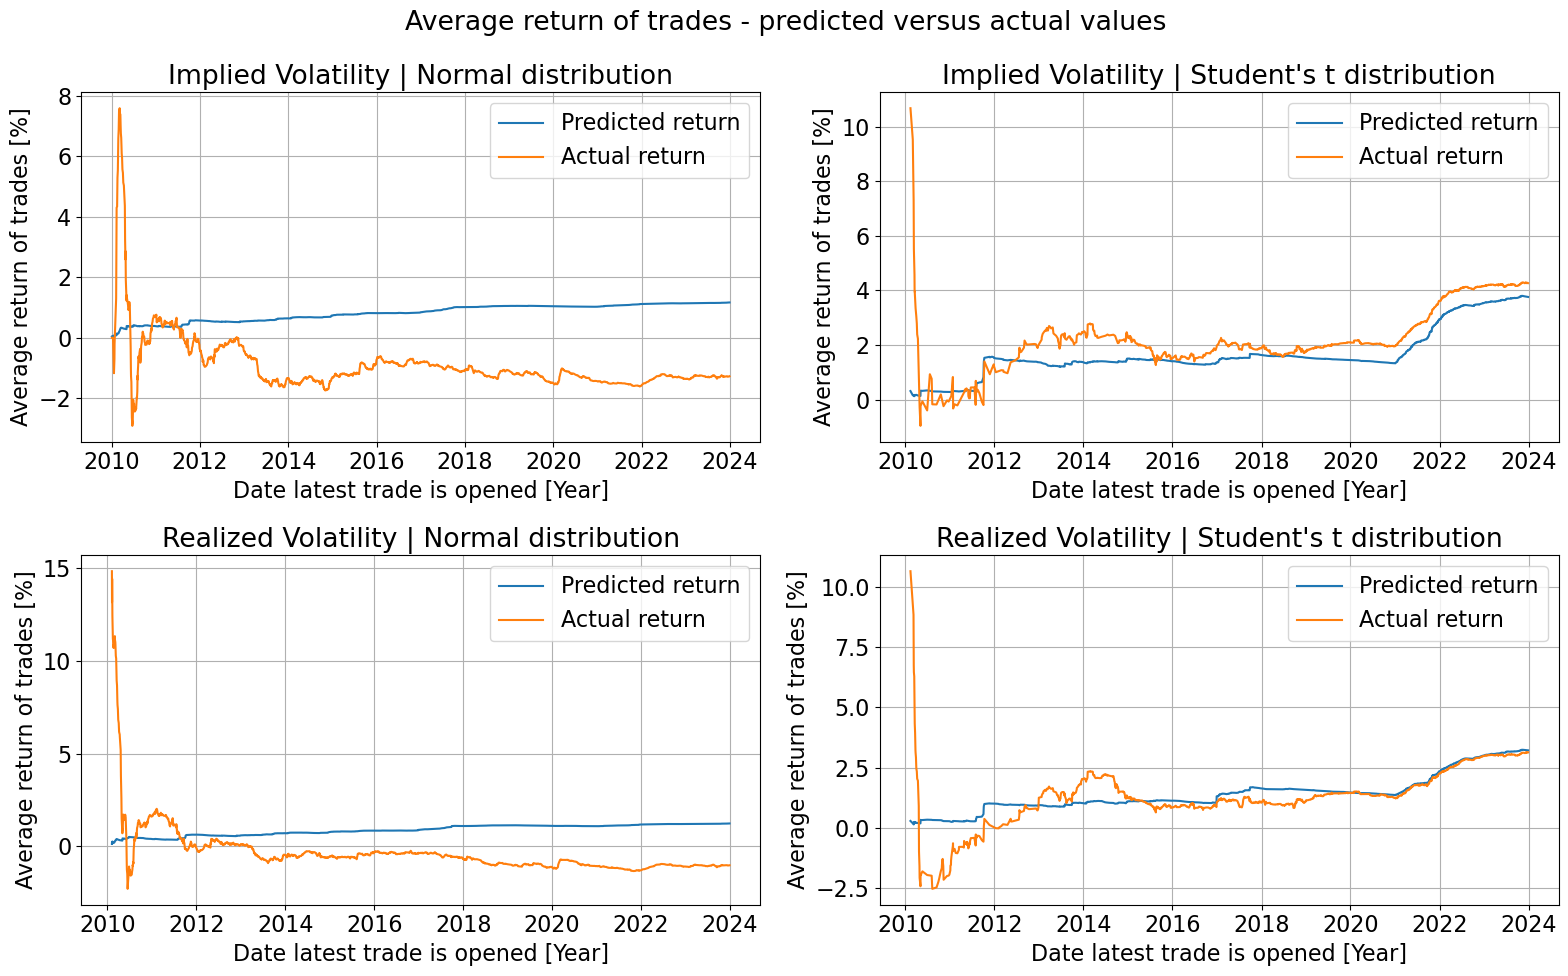

In [15]:
# Plot 1: Expanding mean plot of returns
plt.figure(figsize=(16, 10))
plt.suptitle('Average return of trades - predicted versus actual values')

plt.subplot(2,2,1)
plt.plot(df_buy_mean_array[0,0].index, df_buy_mean_array[0,0]['EV% mean'], label='Predicted return')
plt.plot(df_buy_mean_array[0,0].index, df_buy_mean_array[0,0]['actual return % mean'], label='Actual return')
plt.legend()
plt.grid()
plt.xlabel('Date latest trade is opened [Year]')
plt.ylabel('Average return of trades [%]')
plt.title('Implied Volatility | Normal distribution')

plt.subplot(2,2,2)
plt.plot(df_buy_mean_array[0,1].index, df_buy_mean_array[0,1]['EV% mean'], label='Predicted return')
plt.plot(df_buy_mean_array[0,1].index, df_buy_mean_array[0,1]['actual return % mean'], label='Actual return')
plt.legend()
plt.grid()
plt.xlabel('Date latest trade is opened [Year]')
plt.ylabel('Average return of trades [%]')
plt.title('Implied Volatility | Student\'s t distribution')

plt.subplot(2,2,3)
plt.plot(df_buy_mean_array[1,0].index, df_buy_mean_array[1,0]['EV% mean'], label='Predicted return')
plt.plot(df_buy_mean_array[1,0].index, df_buy_mean_array[1,0]['actual return % mean'], label='Actual return')
plt.legend()
plt.grid()
plt.xlabel('Date latest trade is opened [Year]')
plt.ylabel('Average return of trades [%]')
plt.title('Realized Volatility | Normal distribution')

plt.subplot(2,2,4)
plt.plot(df_buy_mean_array[1,1].index, df_buy_mean_array[1,1]['EV% mean'], label='Predicted return')
plt.plot(df_buy_mean_array[1,1].index, df_buy_mean_array[1,1]['actual return % mean'], label='Actual return')
plt.legend()
plt.grid()
plt.xlabel('Date latest trade is opened [Year]')
plt.ylabel('Average return of trades [%]')
plt.title('Realized Volatility | Student\'s t distribution')

plt.tight_layout()
plt.show()